In [93]:
# to create folders from split image sets
import os, shutil

# import torch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# for counting examples of each class
from collections import Counter

# for computing means and stds of images in different folders
import glob
import matplotlib.pyplot as plt
import numpy as np

# for counting time
import time

# for confusion matrix
from sklearn.metrics import confusion_matrix

In [135]:
# overwriting flags
USE_LARGE_SET = True                         # will create new folders (*_train and *_test) locally if True, BE AWARE!
BEST_OF_TWELVE = False                        # will lock some hyperparameters
BEST_FOUND = False                           # will lock some hyperparameters
BEST_SMALL_FOUND = True                     # will lock some hyperparameters

# environment setup
USE_DATA_AUG = False                          # experimental to avoid increasing loss
GRAD_CLIP = 5                               # experimental to avoid grad exploding
LARGE_SET_FOLDER = 'training_v2'              # expect the original folder from the unzipped file
SMALL_SET_FOLDER = 'training_personal'        # expect 3 images in each of A~I, K folders
CLASS_FOLDERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K']
SEED = 0
torch.manual_seed(SEED)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

# manually updated hyperparameter
LIST_LOSS_FUN = ['MESLoss', 'CrossEntropy']
LOSS_FUN = LIST_LOSS_FUN[1]            # loss function
LIST_OPTIM = ['SGD', 'Adam']
OPTIM = LIST_OPTIM[0]                  # optimizer
BATCH_NORM = True                      # batch norm

# manually updated/overwritten hyperparameter 
LIST_BATCH_SIZE = [10, 4, 32]
BATCH_SIZE = LIST_BATCH_SIZE[2]        # batch size
LIST_LEARNING_RATE = [0.01, 0.1]
LEARNING_RATE = LIST_LEARNING_RATE[1]  # learning rate
LIST_EPOCHS = [100]
EPOCHS = LIST_EPOCHS[0]                # epochs

# hyperparameters only for the set of 12 CNN models
LIST_CONV_LAYERS = [1, 2, 4]
CONV_LAYERS = LIST_CONV_LAYERS[2]       # conv layer count (only for LARGE SET)
LIST_KERNELS = [10, 30]
KERNELS = LIST_KERNELS[1]               # kernel channels (only for LARGE SET)

# overwriting for the BEST OF 12 CNN:
if BEST_OF_TWELVE:
    USE_LARGE_SET = True
    BEST_FOUND = False
    BEST_SMALL_FOUND = False
    USE_DATA_AUG = False
    OPTIM = 'SGD'
    BATCH_SIZE = 32
    LEARNING_RATE = 0.1
    EPOCHS = 100
elif BEST_FOUND:
    USE_LARGE_SET = True
    BEST_SMALL_FOUND = False
    USE_DATA_AUG = True
    LOSS_FUN = 'CrossEntropy'
    OPTIM = 'SGD'
    # BATCH_NORM = True      built-in
    BATCH_SIZE = 32
    LEARNING_RATE = 0.1
    EPOCHS = 100
elif BEST_SMALL_FOUND:
    USE_LARGE_SET = True
    USE_DATA_AUG = True
    LOSS_FUN = 'CrossEntropy'
    OPTIM = 'SGD'
    # BATCH_NORM = True      built-in
    BATCH_SIZE = 32
    LEARNING_RATE = 0.1
    EPOCHS = 100

cuda:0


Using the large image set(training_v2), spilting...
Split folders with class subfolders already exist. Completed.

Computing Mean and Standard Deviation of all images...
  top folder: training_v2_split


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  3815 images
  mean in (R,G,B): [175.34406721 157.83261068 144.68260742]
  std in (R,G,B): [32.93733279 41.33637227 44.02010819]
Completed.

Defining train_transform with Data Augmentation...
Defining normal test_transform...
Completed.

Loading images into PyTorch Dataset...
  train folder: training_v2_split/train/
  test folder: training_v2_split/test/
  train set:
    set size: 2557
    set distribution: {'A': 263, 'B': 267, 'C': 237, 'D': 271, 'E': 259, 'F': 267, 'G': 268, 'H': 269, 'I': 272, 'K': 184}
  test set:
    set size: 1258
    set distribution: {'A': 133, 'B': 132, 'C': 117, 'D': 133, 'E': 124, 'F': 131, 'G': 128, 'H': 132, 'I': 136, 'K': 92}
Completed.

Preview of the training set loader:


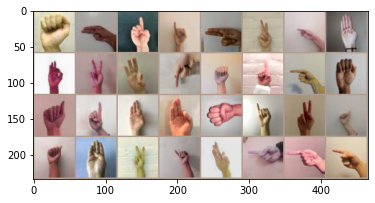

    A     H     D     I     H     K     G     B     F     K     F     G     E     D     G     A     A     D     F     F     E     I     K     A     A     B     K     I     F     D     G     G
Completed.

The best small CNN:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 54, 54]             308
       BatchNorm2d-2           [-1, 11, 54, 54]              22
         MaxPool2d-3           [-1, 11, 27, 27]               0
            Conv2d-4           [-1, 10, 25, 25]           1,000
       BatchNorm2d-5           [-1, 10, 25, 25]              20
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 10, 10, 10]             910
       BatchNorm2d-8           [-1, 10, 10, 10]              20
         MaxPool2d-9             [-1, 10, 5, 5]               0
           Conv2d-10             [-1, 20, 3, 3]           1,820
      B

<ipython-input-122-dc150007544a>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_images = torch.tensor(tensor_images, dtype=torch.float).to(DEVICE)
<ipython-input-122-dc150007544a>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_one_hots = torch.tensor(tensor_alphabets, dtype=torch.long).to(DEVICE)
<ipython-input-122-dc150007544a>:48: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(CNN.parameters(), GRAD_CLIP)
<ipython-input-122-dc150007544a>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

   Epoch 0:
      train loss: 1.5997457057237625
      train accuracy: 0.4779037935080172
      test loss: 1.1752235546708107
      test accuracy: 0.6550079491255962
   Epoch 1:
      train loss: 1.032515186071396
      train accuracy: 0.7039499413375049
      test loss: 1.0001960381865502
      test accuracy: 0.699523052464229
   Epoch 2:
      train loss: 0.8713531073182821
      train accuracy: 0.7434493547125538
      test loss: 0.8486434236168862
      test accuracy: 0.753577106518283
   Epoch 3:
      train loss: 0.7590901371091604
      train accuracy: 0.7751271020727415
      test loss: 0.8091395154595376
      test accuracy: 0.7432432432432432
   Epoch 4:
      train loss: 0.7050519201904535
      train accuracy: 0.7825576847868596
      test loss: 0.7246174186468124
      test accuracy: 0.7678855325914149
   Epoch 5:
      train loss: 0.6306092895567417
      train accuracy: 0.804849432929214
      test loss: 0.6822944566607475
      test accuracy: 0.7885532591414944
   Epoch

   Epoch 50:
      train loss: 0.22167065907269717
      train accuracy: 0.9319515056707078
      test loss: 0.46278424449265004
      test accuracy: 0.8569157392686805
   Epoch 51:
      train loss: 0.2016307615209371
      train accuracy: 0.9339069221744232
      test loss: 0.4548686988651752
      test accuracy: 0.8680445151033387
   Epoch 52:
      train loss: 0.20516406930983067
      train accuracy: 0.9335158388736801
      test loss: 0.4719034094363451
      test accuracy: 0.8640699523052464
   Epoch 53:
      train loss: 0.19837804716080426
      train accuracy: 0.9366445052796245
      test loss: 0.45225276555866
      test accuracy: 0.8640699523052464
   Epoch 54:
      train loss: 0.19546995982527732
      train accuracy: 0.9354712553773954
      test loss: 0.449339833855629
      test accuracy: 0.8648648648648649
   Epoch 55:
      train loss: 0.19256996205076576
      train accuracy: 0.9354712553773954
      test loss: 0.4603742441162467
      test accuracy: 0.864864864864

   Epoch 99:
      train loss: 0.14648784464225173
      train accuracy: 0.9534610872115761
      test loss: 0.44992189966142176
      test accuracy: 0.8672496025437202


<ipython-input-122-dc150007544a>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_images = torch.tensor(tensor_images, dtype=torch.float).to(DEVICE)


Best Test Acccuracy: 0.8918918918918919
Total runtime of 100 epochs: 806.9036595821381s
Completed.

Print training & testing loss/accuracy over epoch/time...
Completed.

[[105   1   1   8  14   0   1   0   3   0]
 [  1 114   0   2   0   8   0   2   1   4]
 [  1   0 103   1   4   3   0   4   1   0]
 [  2   0   1 119   1   3   3   1   1   2]
 [ 13   6   1   0  99   1   0   0   4   0]
 [  1   5   0   0   2 121   1   0   1   0]
 [  2   0   0   4   2   0 107  10   2   1]
 [  2   0   0   2   0   0   7 119   1   1]
 [  1   0   4   0   3   2   4   1 120   1]
 [  0   1   0   2   0   2   0   3   0  84]]


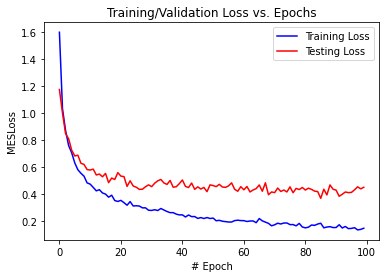

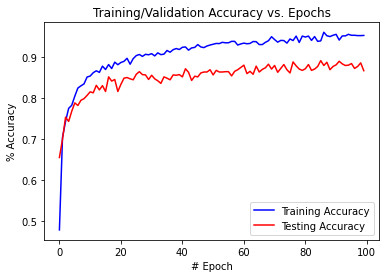

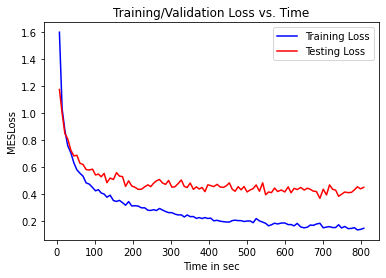

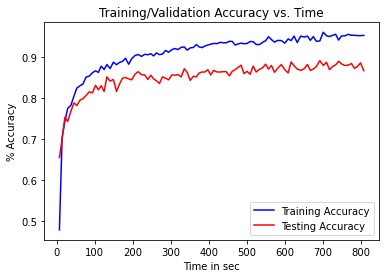

In [150]:
# main (run all below first)
def main():
    if SpiltLargeSet(USE_LARGE_SET, LARGE_SET_FOLDER, CLASS_FOLDERS) == False: return False
    train_transform, test_transform, Mean, Std = DefineTransform(USE_DATA_AUG, USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER)
    trainset, trainset_dist, testset, testset_dist = LoadDataset(train_transform, test_transform, USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER)
    trainloader = Data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = Data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
    PreviewDataLoader(trainloader, trainset, Mean, Std)
    if USE_LARGE_SET == False:
        print('A basic CNN:')
        CNN = BasicCNN()
    elif BEST_OF_TWELVE:
        print('The best of 12 CNNs:')
        CNN = BestTwelveCNN(BATCH_NORM)
    elif BEST_FOUND:
        print('The best CNN found:')
        CNN = BestCNN()
    elif BEST_SMALL_FOUND:
        print('The best small CNN:')
        CNN = BestSmallCNN()
    else:
        print('Creating a customized CNN...')
        CNN = TwelveCNN(CONV_LAYERS, KERNELS)
    CNN = CNN.to(DEVICE)
    print(summary(CNN, (3,56,56)))
    print('Completed.', end='\n\n')
    loss_train, loss_test, accuracy_train, accuracy_test, timeline, total_time, last_pred, last_label, model = TrainingLoop(CNN=CNN,
                                                                                              trainloader=trainloader,
                                                                                              testloader=testloader,
                                                                                              testset=testset,
                                                                                              LOSS_FUN=LOSS_FUN,
                                                                                              OPTIM=OPTIM,
                                                                                              BATCH_SIZE=BATCH_SIZE,
                                                                                              LEARNING_RATE=LEARNING_RATE,
                                                                                              EPOCHS=EPOCHS,
                                                                                              DEVICE=DEVICE,
                                                                                              GRAD_CLIP = GRAD_CLIP)
    PlotResults(loss_train, loss_test, accuracy_train, accuracy_test, timeline)
    if BEST_FOUND:
        torch.save(model.state_dict(), 'MyBest.pt')
    elif BEST_SMALL_FOUND:
        torch.save(model.state_dict(), 'MyBestSmall.pt')
    print(confusion_matrix(last_label, last_pred))

if __name__ == '__main__':
    main()

In [30]:
# Spilt the large image set into folders of train image set and test image set
def SpiltLargeSet(USE_LARGE_SET, LARGE_SET_FOLDER, CLASS_FOLDERS):
    if USE_LARGE_SET == False:
        print('Using a small image set(30 personal samples), no spilting.', end='\n\n')
        return True
    print('Using the large image set(' + LARGE_SET_FOLDER + '), spilting...')
    
    if os.path.exists(LARGE_SET_FOLDER) == False:
        print('Cannot find the large image set(' + LARGE_SET_FOLDER + ').')
        return False
    
    train_folder = './' + LARGE_SET_FOLDER + '_split/train'
    test_folder = './' + LARGE_SET_FOLDER + '_split/test'
    if os.path.exists(train_folder + '/' + CLASS_FOLDERS[-1]) and os.path.exists(test_folder + '/' + CLASS_FOLDERS[-1]):
        print('Split folders with class subfolders already exist. Completed.', end='\n\n')
        return True
    if os.path.exists(train_folder) == False:
        os.makedirs(train_folder)
        print('  ' + train_folder + ' created')
    else:
        print('  ' + train_folder + ' exists')
    if os.path.exists(test_folder) == False:
        os.makedirs(test_folder)
        print('  ' + test_folder + ' created')
    else:
        print('  ' + test_folder + ' exists')
    
    for class_folder in CLASS_FOLDERS:
        from_folder = './' + LARGE_SET_FOLDER + '/' + class_folder
        print('Copying from ' + from_folder + '...')
        
        to_train_class_folder = train_folder + '/' + class_folder
        to_test_class_folder = test_folder + '/' + class_folder
        if os.path.exists(to_train_class_folder) == False:
            os.mkdir(to_train_class_folder)
            print('    ' + to_train_class_folder + ' created')
        else:
            print('    ' + to_train_class_folder + ' exists')
        if os.path.exists(to_test_class_folder) == False:
            os.mkdir(to_test_class_folder)
            print('    ' + to_test_class_folder + ' created')
        else:
            print('    ' + to_test_class_folder + ' exists')
        
        for one_jpg in glob.glob(os.path.join(from_folder, '*_1.jpg')):
            shutil.copy(one_jpg, to_train_class_folder)
        for two_jpg in glob.glob(os.path.join(from_folder, '*_2.jpg')):
            shutil.copy(two_jpg, to_train_class_folder)
        for three_jpg in glob.glob(os.path.join(from_folder, '*_3.jpg')):
            shutil.copy(three_jpg, to_test_class_folder)
        print('  2-to-1 split for ' + class_folder + ' completed.')
    print('Completed.', end='\n\n')
    return True

In [118]:
# define transformation for loaded images
def DefineTransform(USE_DATA_AUG, USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER):
    RGBMean, RGBStd = FindImageSetRGBMeanStd(USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER)
    if USE_DATA_AUG:
        print('Defining train_transform with Data Augmentation...')
        train_transform = transforms.Compose(
            [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
             transforms.RandomCrop(size=64, padding=4, padding_mode='edge'),
             transforms.RandomResizedCrop(size=56, scale=(0.9,1.0), ratio=(0.8,1.2)),
             transforms.ToTensor(),
             transforms.Normalize(mean=RGBMean, std=RGBStd)])
    else:
        print('Defining normal train_transform...')
        train_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=RGBMean, std=RGBStd)])
    print('Defining normal test_transform...')
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=RGBMean, std=RGBStd)])
    print('Completed.', end='\n\n')
    return train_transform, test_transform, RGBMean, RGBStd

# find the average RGB mean and standard deviation of the image set
def FindImageSetRGBMeanStd(USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER):
    print('Computing Mean and Standard Deviation of all images...')
    if USE_LARGE_SET:
        print('  top folder:', LARGE_SET_FOLDER+'_split')
        path = './' + LARGE_SET_FOLDER + '_split/*/*/*.jpg'
    else:
        print('  folder:', SMALL_SET_FOLDER)
        path = './' + SMALL_SET_FOLDER + '/*/*.jpg'
    count = 0
    RGBMean = np.array([0, 0, 0])
    RGBStd = np.array([0, 0, 0])
    for filename in glob.glob(path):
        count += 1
        npImage = plt.imread(filename)
        RGBMean = RGBMean + np.mean(npImage, axis=(0,1))
        RGBStd = RGBStd + np.std(npImage, axis=(0,1))
    RGBMean /= count
    RGBStd /= count
    print(' ', count, 'images')
    print('  mean in (R,G,B):', RGBMean)
    print('  std in (R,G,B):', RGBStd)
    print('Completed.', end='\n\n')
    return (RGBMean[0]/255, RGBMean[1]/255, RGBMean[2]/255), (RGBStd[0]/255, RGBStd[1]/255, RGBStd[2]/255)

In [11]:
# load images to pytorch datasets (1 for training, 1 for testing; identical )
def LoadDataset(train_transform, test_transform, USE_LARGE_SET, LARGE_SET_FOLDER, SMALL_SET_FOLDER):
    print('Loading images into PyTorch Dataset...')
    if USE_LARGE_SET:
        print('  train folder: ' + LARGE_SET_FOLDER + '_split/train/')
        train_root = './' + LARGE_SET_FOLDER + '_split/train/'
        print('  test folder: ' + LARGE_SET_FOLDER + '_split/test/')
        test_root = './' + LARGE_SET_FOLDER + '_split/test/'
    else:
        print('  train and test folder: ' + SMALL_SET_FOLDER + '/')
        train_root = './' + SMALL_SET_FOLDER + '/'
        test_root = train_root
    trainset = datasets.ImageFolder(train_root, transform = train_transform)
    print('  train set:')
    trainset_dist = CountForClasses(trainset)
    testset = datasets.ImageFolder(test_root, transform = test_transform)
    print('  test set:')
    testset_dist = CountForClasses(testset)
    print('Completed.', end='\n\n')
    return trainset, trainset_dist, testset, testset_dist

# count numbers of all classes in a dataset
def CountForClasses(dataset):
    print('    set size:', len(dataset))
    idx_to_class = {idx: clss for clss, idx in (dataset.class_to_idx).items()}
    idx_to_count = Counter(dataset.targets)
    class_to_count = {idx_to_class[idx]: idx_to_count[idx] for idx in range(len(idx_to_class))}
    print('    set distribution:', class_to_count)
    return class_to_count

In [12]:
# preview a batch of images
def PreviewDataLoader(dataloader, dataset, Mean, Std):
    print('Preview of the training set loader:')
    batches = iter(dataloader)
    images, labels = batches.next()
    UnnormalizeImage(torchvision.utils.make_grid(images), Mean, Std)
    idx_to_class = {idx: clss for clss, idx in (dataset.class_to_idx).items()}
    print(' '.join('%5s' % idx_to_class[int(labels[j])] for j in range(len(labels))))
    print('Completed.', end='\n\n')

# un-normalize a normalized tensor image to a numpy image
def UnnormalizeImage(tensor_image, Mean, Std):
    np_image = np.transpose(tensor_image.numpy(), (1,2,0))
    base = np.ones(np_image.shape)
    mean_expanded = np.reshape(np.array(Mean), (1,1,3)) * base
    std_expanded = np.reshape(np.array(Std), (1,1,3)) * base
    unnorm_image = np_image * std_expanded + mean_expanded
    plt.imshow(unnorm_image)
    plt.show()

In [13]:
# class of the basic CNN for the small image set
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*11*11, 100)
        self.fc2 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 8*11*11)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [122]:
# training loop
def TrainingLoop(CNN, trainloader, testloader, testset, LOSS_FUN, OPTIM, BATCH_SIZE, LEARNING_RATE, EPOCHS, DEVICE, GRAD_CLIP):
    print('Training...')
    if LOSS_FUN == 'MESLoss':
        print('   Mean Squared Loss', end=', ')
        LossFunction = nn.MSELoss()
    elif LOSS_FUN == 'CrossEntropy':
        print('   Cross Entropy Loss', end=', ')
        LossFunction = nn.CrossEntropyLoss()
    else:
        print('   ERROR in Loss', end=', ')
    
    best_accuracy = 0.0
    
    if OPTIM == 'SGD':
        print('Stochastic Gradient Descent(LR='+ str(LEARNING_RATE) +')')
        optimizer = optim.SGD(CNN.parameters(), lr=LEARNING_RATE)
    elif OPTIM == 'Adam':
        print('ADAM(LR='+ str(LEARNING_RATE) +')')
        optimizer = optim.Adam(CNN.parameters(), lr=LEARNING_RATE)
    else:
        print('ERROR in Optimizer')
    CNN = CNN.to(DEVICE)
    timeline = []
    loss_train = []
    loss_test = []
    accuracy_train = []
    accuracy_test = []
    one_hot_collection = torch.tensor(np.eye(len(testset.class_to_idx)), dtype=torch.float).to(DEVICE)
    start_time = time.time()
    for epoch in range(EPOCHS):
        loss_per_epoch = 0.0
        correct_per_epoch = 0
        total_per_epoch = 0
        batches_per_epoch = 0
        for i, data in enumerate(trainloader, 0):
            tensor_images, tensor_alphabets = data
            tensor_images = torch.tensor(tensor_images, dtype=torch.float).to(DEVICE)
            if LOSS_FUN == 'CrossEntropy':
                tensor_one_hots = torch.tensor(tensor_alphabets, dtype=torch.long).to(DEVICE)
            else:
                tensor_alphabets = torch.tensor(tensor_alphabets, dtype=torch.float).to(DEVICE)
                tensor_one_hots = one_hot_collection[(tensor_alphabets.cpu()).numpy()].to(DEVICE)
            optimizer.zero_grad()
            outputs = CNN(tensor_images)
            loss = LossFunction(outputs, tensor_one_hots)
            loss.backward()
            nn.utils.clip_grad_norm(CNN.parameters(), GRAD_CLIP)
            optimizer.step()
            loss_per_epoch += loss.item()
            total_per_epoch += len(tensor_alphabets)
            correct_per_epoch += sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == tensor_alphabets.cpu().detach().numpy())
            batches_per_epoch = i
        loss_train.append(loss_per_epoch/(batches_per_epoch+1))
        accuracy_train.append(correct_per_epoch/total_per_epoch)
        loss_per_epoch = 0.0
        correct_per_epoch = 0
        total_per_epoch = 0
        batches_per_epoch = 0
        for i, data in enumerate(testloader, 0):
            tensor_images, tensor_alphabets = data
            tensor_images = torch.tensor(tensor_images, dtype=torch.float).to(DEVICE)
            if LOSS_FUN == 'CrossEntropy':
                tensor_one_hots = torch.tensor(tensor_alphabets, dtype=torch.long).to(DEVICE)
            else:
                tensor_alphabets = torch.tensor(tensor_alphabets, dtype=torch.float).to(DEVICE)
                tensor_one_hots = one_hot_collection[(tensor_alphabets.cpu()).numpy()].to(DEVICE)
            outputs = CNN(tensor_images)
            loss = LossFunction(outputs, tensor_one_hots)
            loss_per_epoch += loss.item()
            total_per_epoch += len(tensor_alphabets)
            correct_per_epoch += sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == tensor_alphabets.cpu().detach().numpy())
            batches_per_epoch = i
        timeline.append(time.time() - start_time)
        loss_test.append(loss_per_epoch/(batches_per_epoch+1))
        accuracy_test.append(correct_per_epoch/total_per_epoch)
        
        print('   Epoch ' + str(epoch) + ':')
        print('      train loss:', loss_train[-1])
        print('      train accuracy:', accuracy_train[-1])
        print('      test loss:', loss_test[-1])
        print('      test accuracy:', accuracy_test[-1])
        
        if best_accuracy < accuracy_test[-1]:
            model = CNN
            best_accuracy = accuracy_test[-1]
    
    last_pred = []
    last_label = []
    if epoch == (EPOCHS - 1) and LOSS_FUN == 'CrossEntropy':
        for i, data in enumerate(testloader, 0):
            tensor_images, tensor_alphabets = data
            tensor_images = torch.tensor(tensor_images, dtype=torch.float).to(DEVICE)
            outputs = CNN(tensor_images)
            np_outputs = np.argmax(outputs.cpu().detach().numpy(), axis = 1)
            for i in np_outputs:
                last_pred.append(i)
            np_label = tensor_alphabets.cpu().detach().numpy()
            for i in np_label:
                last_label.append(i)
    model = model.cpu()
    
    print('Best Test Acccuracy:', best_accuracy)
    
    total_time = timeline[-1]
    print('Total runtime of ' + str(EPOCHS) + ' epochs: ' + str(total_time) + 's')
    print('Completed.', end='\n\n')
    return loss_train, loss_test, accuracy_train, accuracy_test, timeline, total_time, last_pred, last_label, model

In [47]:
# print training & testing loss and accuracy
def PlotResults(loss_train, loss_test, accuracy_train, accuracy_test, timeline):
    print('Print training & testing loss/accuracy over epoch/time...')
    plt.figure(1)
    plt.plot(loss_train, 'b', label='Training Loss')
    plt.plot(loss_test, 'r', label='Testing Loss')
    plt.xlabel('# Epoch')
    plt.ylabel('MESLoss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss vs. Epochs')
    
    plt.figure(2)
    plt.plot(accuracy_train, 'b', label='Training Accuracy')
    plt.plot(accuracy_test, 'r', label='Testing Accuracy')
    plt.xlabel('# Epoch')
    plt.ylabel('% Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training/Validation Accuracy vs. Epochs')
    
    plt.figure(3)
    plt.plot(timeline, loss_train, 'b', label='Training Loss')
    plt.plot(timeline, loss_test, 'r', label='Testing Loss')
    plt.xlabel('Time in sec')
    plt.ylabel('MESLoss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss vs. Time')
    
    plt.figure(4)
    plt.plot(timeline, accuracy_train, 'b', label='Training Accuracy')
    plt.plot(timeline, accuracy_test, 'r', label='Testing Accuracy')
    plt.xlabel('Time in sec')
    plt.ylabel('% Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training/Validation Accuracy vs. Time')
    print('Completed.', end='\n\n')

In [24]:
# grid search net
class TwelveCNN(nn.Module):
    def __init__(self, convNum, kernNum):
        super(TwelveCNN,self).__init__()
        self.convNum = convNum
        self.kernNum = kernNum
        print('conv:', self.convNum)
        print('kern:', self.kernNum)
        if self.convNum == 1:
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            if self.kernNum == 30:
                self.fc1 = nn.Linear(21870, 32)
            elif self.kernNum == 10:
                self.fc1 = nn.Linear(7290, 32)
        elif self.convNum == 2:
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=self.kernNum, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            if self.kernNum == 30:
                self.fc1 = nn.Linear(4320, 32)
            elif self.kernNum == 10:
                self.fc1 = nn.Linear(1440, 32)
        elif self.convNum == 4:
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=self.kernNum, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv3 = nn.Conv2d(in_channels=self.kernNum, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv4 = nn.Conv2d(in_channels=self.kernNum, out_channels=self.kernNum, kernel_size=3, stride=1)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            if self.kernNum == 30:
                self.fc1 = nn.Linear(30, 32)
            elif self.kernNum == 10:
                self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        if self.convNum == 1:
            x = self.pool1(F.relu(self.conv1(x)))
            if self.kernNum == 30:
                x = x.view(-1, 21870)
            elif self.kernNum == 10:
                x = x.view(-1, 7290)
        elif self.convNum == 2:
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            if self.kernNum == 30:
                x = x.view(-1, 4320)
            elif self.kernNum == 10:
                x = x.view(-1, 1440)
        elif self.convNum == 4:
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            x = self.pool4(F.relu(self.conv4(x)))
            if self.kernNum == 30:
                x = x.view(-1, 30)
            elif self.kernNum == 10:
                x = x.view(-1, 10)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [34]:
# the best of 12 CNN
class BestTwelveCNN(nn.Module):
    def __init__(self, batch_norm):
        super(BestTwelveCNN,self).__init__()
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.conv1_bn = nn.BatchNorm2d(30)
            self.conv2_bn = nn.BatchNorm2d(30)
            self.conv3_bn = nn.BatchNorm2d(30)
            self.conv4_bn = nn.BatchNorm2d(30)
            self.fc1_bn = nn.BatchNorm1d(32)
            self.fc2_bn = nn.BatchNorm1d(10)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(30, 32)
        self.fc2 = nn.Linear(32, 10)
        
    
    def forward(self, x):
        if self.batch_norm:
            x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
            x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
            x = self.pool3(F.relu(self.conv3_bn(self.conv3(x))))
            x = self.pool4(F.relu(self.conv4_bn(self.conv4(x))))
            x = x.view(-1, 30)
            x = self.fc1_bn(self.fc1(x))
            x = self.fc2_bn(self.fc2(x))
        else:
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            x = self.pool4(F.relu(self.conv4(x)))
            x = x.view(-1, 30)
            x = self.fc1(x)
            x = self.fc2(x)
        return x

In [125]:
# the best CNN
class BestCNN(nn.Module):
    def __init__(self):
        super(BestCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, stride=1)
        self.conv1_bn = nn.BatchNorm2d(30)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.conv2_bn = nn.BatchNorm2d(30)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.conv3_bn = nn.BatchNorm2d(30)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1)
        self.conv4_bn = nn.BatchNorm2d(30)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(30, 32)
        self.fc1_bn = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 10)
        self.fc2_bn = nn.BatchNorm1d(10)
        
    
    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.conv1_bn(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.conv2_bn(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.conv3_bn(self.conv3(x))))
        x = self.pool4(F.leaky_relu(self.conv4_bn(self.conv4(x))))
        x = x.view(-1, 30)
        x = self.fc1_bn(self.fc1(x))
        x = self.fc2_bn(self.fc2(x))
        return x

In [149]:
# the best small CNN
class BestSmallCNN(nn.Module):
    def __init__(self):
        super(BestSmallCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=11, kernel_size=3, stride=1)
        self.conv1_bn = nn.BatchNorm2d(11)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=11, out_channels=10, kernel_size=3, stride=1)
        self.conv2_bn = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1)
        self.conv3_bn = nn.BatchNorm2d(10)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1)
        self.conv4_bn = nn.BatchNorm2d(20)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(20, 25)
        self.fc1_bn = nn.BatchNorm1d(25)
        self.fc2 = nn.Linear(25, 10)
        self.fc2_bn = nn.BatchNorm1d(10)
        
    
    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.conv1_bn(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.conv2_bn(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.conv3_bn(self.conv3(x))))
        x = self.pool4(F.leaky_relu(self.conv4_bn(self.conv4(x))))
        x = x.view(-1, 20)
        x = self.fc1_bn(self.fc1(x))
        x = self.fc2_bn(self.fc2(x))
        return x